In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

Load data and Show information

In [4]:
DATA_PATH = "/content/drive/MyDrive/Undergrad/Semester-7/DWDM_Preprocessing-Assignment/Data"
df = pd.read_csv(os.path.join(DATA_PATH, "taxi_trip_data.csv"))
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 17 columns):
 #   Column               Dtype  
---  ------               -----  
 0   vendor_id            int64  
 1   pickup_datetime      object 
 2   dropoff_datetime     object 
 3   passenger_count      int64  
 4   trip_distance        float64
 5   rate_code            int64  
 6   store_and_fwd_flag   object 
 7   payment_type         int64  
 8   fare_amount          float64
 9   extra                float64
 10  mta_tax              float64
 11  tip_amount           float64
 12  tolls_amount         float64
 13  imp_surcharge        float64
 14  total_amount         float64
 15  pickup_location_id   int64  
 16  dropoff_location_id  int64  
dtypes: float64(8), int64(6), object(3)
memory usage: 1.3+ GB
None


In [5]:
# Show first 5 rows
print(df.head())

   vendor_id      pickup_datetime     dropoff_datetime  passenger_count  \
0          2  2018-03-29 13:37:13  2018-03-29 14:17:01                1   
1          2  2018-03-29 13:37:18  2018-03-29 14:15:33                1   
2          2  2018-03-29 13:26:57  2018-03-29 13:28:03                1   
3          2  2018-03-29 13:07:48  2018-03-29 14:03:05                2   
4          2  2018-03-29 14:19:11  2018-03-29 15:19:59                5   

   trip_distance  rate_code store_and_fwd_flag  payment_type  fare_amount  \
0          18.15          3                  N             1         70.0   
1           4.59          1                  N             1         25.0   
2           0.30          1                  N             1          3.0   
3          16.97          1                  N             1         49.5   
4          14.45          1                  N             1         45.5   

   extra  mta_tax  tip_amount  tolls_amount  imp_surcharge  total_amount  \
0    0.0  

# Introduction

The goal of this notebook is to clean and transform the data available for the purpose of later utilizing it in ML algorithms, or for data warehousing purposed.

The data cleaning process can begin to clear out outliers, missing values and other noise which might affect the results of the algorithm. 

## Background

Rides following similar paths in the past will likely take similar routes, and rides during the same hours of the day will also likely take roughly the same amount of time. This gives us a sort of rolling average for distance and time to make the calculation easier, what it doesn't give us, is how much of that distance is sitting in traffic, below 12mph, or driving at normal speeds above 12mph, nor does it account for sitting at red lights.

These values are hard to account for. While patterns can be detected when analysing the data through graphs and other visuals, it doesn't make for a very mathematical or repeatable prediction. We'll need the model to detect these patterns quickly and repeatably to get the most accurate predictions possible, which means some data, such as start and end times should be broken down into chunks that are easier for a machine to read such as the number of minutes per trip, the month, day, day of the week, and year (separately) .

## Plan for Features  

Here are the features of the current dataset that will be kept, as well as a few that will need to be created based on other features:  
- pickup_timestamp  
- dropoff_timestamp  
- trip_distance  
- fare_amount  
- extra  
- mta_tax  
- imp_surcharge  
- total_amount  
- pickup_location_id  
- dropoff_location_id  



# Data Analysis

The **correlation matrix** calculates how the change in one value effects a change in the other value, and assigns a value between -1 and 1 to that correlation.  
Let's review what those correlation values mean before we move on:  

* **-1:** A very strong negative correlation, when value A moves in one direction, value B moves in the opposite direction.  
* **0:**  No correlation between values A and B, when one moves, the other is not effected.  
* **1:**  A very strong positive correlation, as you can guess, this is the opposite of the negative correlation above. When value A moves in one direction, value B follows in the same direction.  

This value isn't related to the rate of change, only the direction of change. Value A moves up, and value B either stays, moves up, or moves down.  

In [6]:
# Generating the correlation matrix
corr = df.corr()

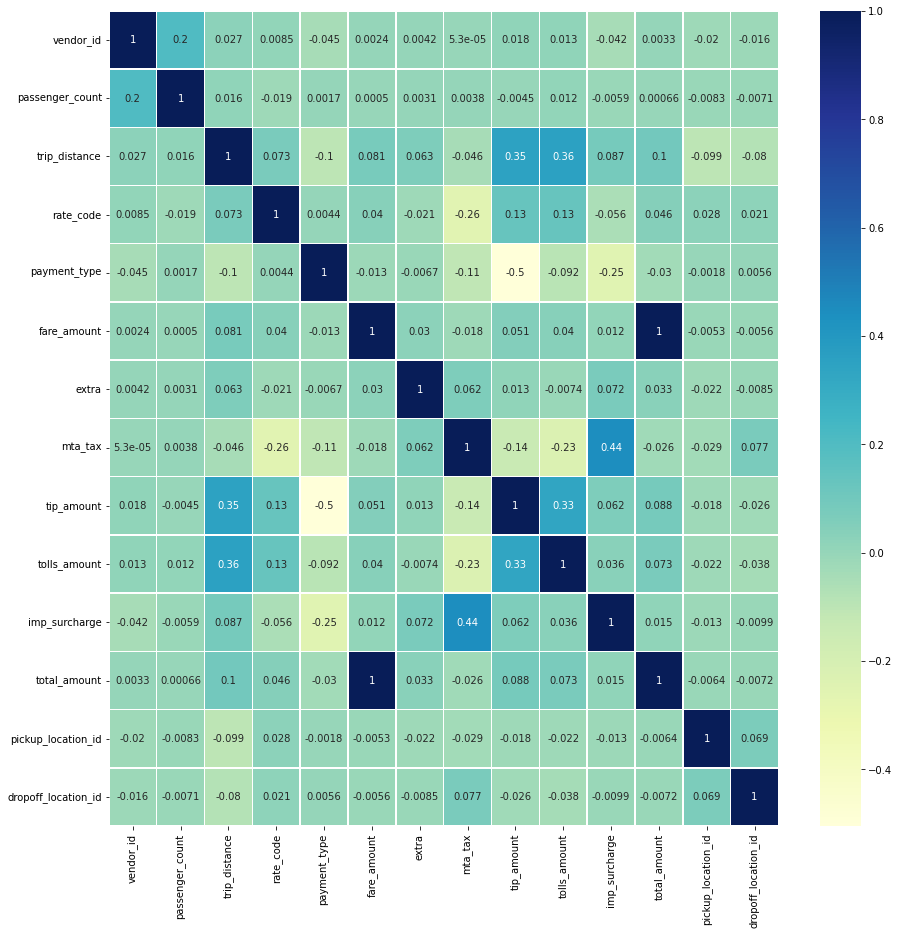

In [7]:
# Drawing the heatmap
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(corr, cmap='YlGnBu', annot=True, linewidths=0.5);

There is already a list of known values that we should keeep. The only remaining values are:  
- **vendor_id** - Vendor of data provider. This definitely won't be used for anything for our model here  
- **rate_code** - The rate code at the end of the trip. Used likely to track certain charges. Has a correlation with tolls and tips but not much with anything else.  
- **sotre_and_fwd_flag** - This is simply a fag that indicates whether a value was stored in vehicle memory before being recorded due to a lack of internet connection. This is useless to us, however, it's currently stored as a string and converting it to a value that can appear in a correlation matrix later might serve useful. While not likely, it could be possible that values are different from those not stored in memory, such as having a higher amount of errors, or some upload process might be altering values in an unexpected way.

In the end, only one column is being dropped right off the start and that's **Vendor ID**. 

In [8]:
df = df.drop('vendor_id', axis=1)
df.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,pickup_location_id,dropoff_location_id
0,2018-03-29 13:37:13,2018-03-29 14:17:01,1,18.15,3,N,1,70.0,0.0,0.0,16.16,10.50,0.3,96.96,161,1
1,2018-03-29 13:37:18,2018-03-29 14:15:33,1,4.59,1,N,1,25.0,0.0,0.5,5.16,0.00,0.3,30.96,13,230
2,2018-03-29 13:26:57,2018-03-29 13:28:03,1,0.30,1,N,1,3.0,0.0,0.5,0.76,0.00,0.3,4.56,231,231
3,2018-03-29 13:07:48,2018-03-29 14:03:05,2,16.97,1,N,1,49.5,0.0,0.5,5.61,5.76,0.3,61.67,231,138
4,2018-03-29 14:19:11,2018-03-29 15:19:59,5,14.45,1,N,1,45.5,0.0,0.5,10.41,5.76,0.3,62.47,87,138


# Data Cleaning  

The following data cleaning steps are assessed and applied:
1. **Remove duplicate rows** - Carefully, as we only want to remove duplicate trips, not duplicates within the values themselves. These values are not required to be unique.
2. Check for **missing values**
3. Check for **zeros and empty strings**. These values won't be "missing" but still aren't valid. Very few columns in this data have valid zeros  
4.**Validate formatting** of data, especially dates  
5. **Strip and normalize strings** - our data doesn't contain any strings, so we can skip this.  

## Remove Duplicates

In [9]:
# Remove duplicates - 
# Rename the dataframe from df to td for temporary data, thus not altering the original dataframe until much later. 
td = df.drop_duplicates()
# less than 1% dropped
print(f"{df.shape[0] - td.shape[0]} duplicate rows dropped. Thats {(df.shape[0] - td.shape[0]) / df.shape[0] * 100}%")
print(f"{td.shape[0]} rows remain.")

607571 duplicate rows dropped. Thats 6.07571%
9392429 rows remain.


## Remove Missing Values

In [10]:
# Checking for missing values
for col in td.columns:
    missing = td[col].isna().sum()
    print(f"Missing values in {col}: {missing}")

Missing values in pickup_datetime: 0
Missing values in dropoff_datetime: 0
Missing values in passenger_count: 0
Missing values in trip_distance: 0
Missing values in rate_code: 0
Missing values in store_and_fwd_flag: 0
Missing values in payment_type: 0
Missing values in fare_amount: 0
Missing values in extra: 0
Missing values in mta_tax: 0
Missing values in tip_amount: 0
Missing values in tolls_amount: 0
Missing values in imp_surcharge: 0
Missing values in total_amount: 0
Missing values in pickup_location_id: 0
Missing values in dropoff_location_id: 0


## Remove Zeros and Empty Strings

In [11]:
# Checking for zeros in numeric columns
def check_for_zeros(td):
    for col in td.columns:
        zeros = td[td[col] == 0].shape[0]
        print(f"Zeros in {col}:{zeros}")
        
check_for_zeros(td)

Zeros in pickup_datetime:0
Zeros in dropoff_datetime:0
Zeros in passenger_count:85779
Zeros in trip_distance:264896
Zeros in rate_code:0
Zeros in store_and_fwd_flag:0
Zeros in payment_type:0
Zeros in fare_amount:12176
Zeros in extra:5048008
Zeros in mta_tax:285657
Zeros in tip_amount:2062555
Zeros in tolls_amount:6253748
Zeros in imp_surcharge:12433
Zeros in total_amount:5725
Zeros in pickup_location_id:0
Zeros in dropoff_location_id:0


**Changes applied so far ...**

* *passenger_count*, *trip_distance*, *fare_amount* and *total_amount* --- all contain zeros.

* It doesn't appear to be a large amount of the overall data.

* Without distance, we can't determine fare amount, even with distance, it's impossible to know which miles were driven above the 12mph threshold, and which were below.

* There isn't much of a choice but to drop these. However, **total_amount** can be corrected by simply adding all of the charge column values together, so I'll keep and fix these rows.

**Dropping rows with 0 values in columns where 0 is not allowed**

In [12]:
# Dropping rows with 0 values in columns where 0 is not allowed
td = td.drop(['passenger_count'], axis=1)
td = td[td['trip_distance'] > 0]
td = td[td['fare_amount'] > 0]

check_for_zeros(td)

Zeros in pickup_datetime:0
Zeros in dropoff_datetime:0
Zeros in trip_distance:0
Zeros in rate_code:0
Zeros in store_and_fwd_flag:0
Zeros in payment_type:0
Zeros in fare_amount:0
Zeros in extra:4836000
Zeros in mta_tax:216469
Zeros in tip_amount:1886004
Zeros in tolls_amount:5980138
Zeros in imp_surcharge:1418
Zeros in total_amount:0
Zeros in pickup_location_id:0
Zeros in dropoff_location_id:0


After dropping rows with zero values in other columns, there remains no zeros in total_amount, so no corrections are necessary here

In [13]:
# Checking how much of the original data ramains
remaining = td.shape[0] / df.shape[0] * 100
print(f"Remaining amount of original dataset: {remaining}%")

Remaining amount of original dataset: 90.99450999999999%


## Validating Data Formats
  
Ensure that the dates are all readable date formats and exist in the same format such as mm/dd/yyyy, for example. 

In [14]:
# Converting to an actual Python/Pandas datetime object ensures that the data is a valid datetime. 
# Then, we  move on to exploring the datetimes available.
td['pickup_datetime'] = pd.to_datetime(td['pickup_datetime'])
td['dropoff_datetime'] = pd.to_datetime(td['dropoff_datetime'])

print('Done.')

Done.


**Inference:** All datetime stamps in the dataset are correctly formatted

The datetime columns are now split up into meaninful columns. The only dropoff information we really need to keep is the hour, and even then, only to calculate the length of the trip. 

In [15]:
td['year'] = pd.to_datetime(td['pickup_datetime']).dt.year
td['month'] = pd.to_datetime(td['pickup_datetime']).dt.month
td['day'] = pd.to_datetime(td['pickup_datetime']).dt.day
td['day_of_week'] = pd.to_datetime(td['pickup_datetime']).dt.dayofweek
td['hour_of_day'] = pd.to_datetime(td['pickup_datetime']).dt.hour

print('Done.')

Done.


## Cleaning Date and Time Data

### Validate Timestamps

In [16]:
# Converting the datetime columns to a numpy array for vectorization
pickup_array = td['pickup_datetime'].values
dropoff_array = td['dropoff_datetime'].values

### Validate Trip Durations

In [17]:
# Getting the new timedelta, this takes less than a second to complete compared to 15+ minutes with apply()
trip_duration = np.subtract(dropoff_array, pickup_array)

# Adding the resulting array to the dataframe in the trip_duration column
td['trip_duration'] = pd.Series(trip_duration)

# Converting the timedelta to number of seconds
td['trip_duration'] = td['trip_duration'].dt.total_seconds()

# Preview the results
td.head()

,pickup_datetime,dropoff_datetime,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,...,imp_surcharge,total_amount,pickup_location_id,dropoff_location_id,year,month,day,day_of_week,hour_of_day,trip_duration
0,2018-03-29 13:37:13,2018-03-29 14:17:01,18.15,3,N,1,70.0,0.0,0.0,16.16,...,0.3,96.96,161,1,2018,3,29,3,13,2388.0
1,2018-03-29 13:37:18,2018-03-29 14:15:33,4.59,1,N,1,25.0,0.0,0.5,5.16,...,0.3,30.96,13,230,2018,3,29,3,13,2295.0
2,2018-03-29 13:26:57,2018-03-29 13:28:03,0.30,1,N,1,3.0,0.0,0.5,0.76,...,0.3,4.56,231,231,2018,3,29,3,13,66.0
3,2018-03-29 13:07:48,2018-03-29 14:03:05,16.97,1,N,1,49.5,0.0,0.5,5.61,...,0.3,61.67,231,138,2018,3,29,3,13,3317.0
4,2018-03-29 14:19:11,2018-03-29 15:19:59,14.45,1,N,1,45.5,0.0,0.5,10.41,...,0.3,62.47,87,138,2018,3,29,3,14,3648.0


Now, the datetime columns can be dropped entirely. 

In [18]:
td.drop(['pickup_datetime', 'dropoff_datetime'], axis=1, inplace=True)

Displaying the dataset's current state ...

In [19]:
td.head()

,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,pickup_location_id,dropoff_location_id,year,month,day,day_of_week,hour_of_day,trip_duration
0,18.15,3,N,1,70.0,0.0,0.0,16.16,10.50,0.3,96.96,161,1,2018,3,29,3,13,2388.0
1,4.59,1,N,1,25.0,0.0,0.5,5.16,0.00,0.3,30.96,13,230,2018,3,29,3,13,2295.0
2,0.30,1,N,1,3.0,0.0,0.5,0.76,0.00,0.3,4.56,231,231,2018,3,29,3,13,66.0
3,16.97,1,N,1,49.5,0.0,0.5,5.61,5.76,0.3,61.67,231,138,2018,3,29,3,13,3317.0
4,14.45,1,N,1,45.5,0.0,0.5,10.41,5.76,0.3,62.47,87,138,2018,3,29,3,14,3648.0


Now that the dates have been broken down properly, a higher level of data clean-up can be performed.

* Any trips with a duration of 0 need to be dropped. These trips won't be useful, and are certainly due to a data entry error.  

* Investigate what years are available in this dataset, how much of the dataset each year makes up, and begin investigating whether we should keep all years, or only specific years by visualizing trends in fare amounts when compared to trip duration and distance. 

In [20]:
td = td[td['trip_duration'] > 0]

In [21]:
list_of_years = td.year.unique()
print(list_of_years)

[2018 2009 2017 2019 2008 2020 2003 2002 2001 2029 2032]


In [22]:
for year in list_of_years:
    year_amount = td[td['year'] == year].shape[0]
    total_amount = td.shape[0]
    
    print(f"{year} makes up {(year_amount / total_amount) * 100}% of the dataset")

2018 makes up 99.99841696039846% of the dataset
2009 makes up 0.0006356143854646263% of the dataset
2017 makes up 0.00020387631231884242% of the dataset
2019 makes up 0.00014391269104859462% of the dataset
2008 makes up 0.0004917016944160317% of the dataset
2020 makes up 1.1992724254049552e-05% of the dataset
2003 makes up 2.3985448508099104e-05% of the dataset
2002 makes up 2.3985448508099104e-05% of the dataset
2001 makes up 2.3985448508099104e-05% of the dataset
2029 makes up 1.1992724254049552e-05% of the dataset
2032 makes up 1.1992724254049552e-05% of the dataset


## Eliminate Off-Trend Data

It's clear that this dataset is HEAVILY weighted towards 2018. For that reason, dropping anything from before 2018 can help avoid skewing the data towards old trends, while keeping anything newer than 2018 might reveal new trends. 

If a dataset of such massive size consists of 99% of the same year, it's likely that the trips from newer years are either invalid data upon collection, and incomplete enough to actually show any trends.  

All rows but 2018 are, therefore, dropped. 

In [23]:
td = td[td['year'] == 2018]
# Evaluate data stats after dropping
td.describe()

,trip_distance,rate_code,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,pickup_location_id,dropoff_location_id,year,month,day,day_of_week,hour_of_day,trip_duration
count,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8338257.0,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06
mean,9.120187e+00,1.154223e+00,1.180907e+00,3.178215e+01,3.469645e-01,4.882261e-01,5.526390e+00,2.174295e+00,2.999538e-01,4.062672e+01,1.528662e+02,1.476428e+02,2018.0,6.459984e+00,1.576347e+01,2.950375e+00,1.380998e+01,2.210049e+03
std,5.879868e+00,6.330880e-01,4.073165e-01,7.560952e+01,5.659283e-01,8.265593e-02,4.568232e+00,3.748963e+00,3.744167e-03,7.668925e+01,6.017347e+01,7.560037e+01,0.0,3.423810e+00,8.640502e+00,1.930177e+00,6.231820e+00,4.865978e+03
min,1.000000e-02,1.000000e+00,1.000000e+00,1.000000e-02,-8.000000e+01,0.000000e+00,0.000000e+00,-5.760000e+00,0.000000e+00,3.100000e-01,1.000000e+00,1.000000e+00,2018.0,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,6.030000e+00,1.000000e+00,1.000000e+00,2.350000e+01,0.000000e+00,5.000000e-01,2.000000e+00,0.000000e+00,3.000000e-01,2.915000e+01,1.320000e+02,8.800000e+01,2018.0,3.000000e+00,9.000000e+00,1.000000e+00,1.000000e+01,1.403000e+03
50%,8.600000e+00,1.000000e+00,1.000000e+00,2.900000e+01,0.000000e+00,5.000000e-01,5.550000e+00,0.000000e+00,3.000000e-01,3.755000e+01,1.380000e+02,1.420000e+02,2018.0,6.000000e+00,1.600000e+01,3.000000e+00,1.400000e+01,1.835000e+03
75%,1.121000e+01,1.000000e+00,1.000000e+00,3.700000e+01,5.000000e-01,5.000000e-01,7.910000e+00,5.760000e+00,3.000000e-01,4.901000e+01,1.860000e+02,2.290000e+02,2018.0,1.000000e+01,2.300000e+01,5.000000e+00,1.900000e+01,2.348000e+03
max,7.655760e+03,9.900000e+01,4.000000e+00,1.874365e+05,2.020000e+01,8.080000e+01,4.220000e+02,9.182500e+02,6.000000e-01,1.874378e+05,2.650000e+02,2.650000e+02,2018.0,1.200000e+01,3.100000e+01,6.000000e+00,2.300000e+01,3.200310e+05


## Trip Fare - Sanity Checks

The value of *total_amount* should be equal to the sum of the *fare_amount*, *mta_tax*, *tip_amount*, *tolls_amount*, *imp_surcharge* and the *extra*.

Calculating total amounts and dropping rows whose values don't "add up"...

### Drop Fare Columns with Negative Values

In [25]:
init_count = len(td)
td = td[td['fare_amount'] >= 0]
td = td[td['extra'] >= 0]
td = td[td['mta_tax'] >= 0]
td = td[td['tip_amount'] >= 0]
td = td[td['imp_surcharge'] >= 0]
td = td[td['tolls_amount'] >= 0]
final_count = len(td)

print(f"Fraction of dataframe retained: {final_count / init_count * 100}%")

Fraction of dataframe retained: 99.99989206377305%


### Verify that the Fare Values Add Up

In [26]:
# Calculating total amounts and dropping rows whose values don't "add up"...
fare = td['fare_amount'].values
extra = np.add(fare, td['extra'].values)
mta_tax = np.add(extra, td['mta_tax'].values)
tip_amount = np.add(mta_tax, td['tip_amount'].values)
imp_surcharge = np.add(tip_amount, td['imp_surcharge'].values)
calculated_total_amount = np.add(imp_surcharge, td['tolls_amount'].values)

td['calculated_total_amount'] = pd.Series(calculated_total_amount)

# validate calculated total by manually adding all relevant columns and comparing to the calculated column
td.head(10)

,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,pickup_location_id,dropoff_location_id,year,month,day,day_of_week,hour_of_day,trip_duration,calculated_total_amount
0,18.15,3,N,1,70.0,0.0,0.0,16.16,10.50,0.3,96.96,161,1,2018,3,29,3,13,2388.0,96.96
1,4.59,1,N,1,25.0,0.0,0.5,5.16,0.00,0.3,30.96,13,230,2018,3,29,3,13,2295.0,30.96
2,0.30,1,N,1,3.0,0.0,0.5,0.76,0.00,0.3,4.56,231,231,2018,3,29,3,13,66.0,4.56
3,16.97,1,N,1,49.5,0.0,0.5,5.61,5.76,0.3,61.67,231,138,2018,3,29,3,13,3317.0,61.67
4,14.45,1,N,1,45.5,0.0,0.5,10.41,5.76,0.3,62.47,87,138,2018,3,29,3,14,3648.0,62.47
5,11.60,1,N,1,42.0,0.0,0.5,14.57,5.76,0.3,63.13,68,138,2018,3,29,3,14,3540.0,63.13
6,5.80,1,N,1,24.0,0.0,0.5,4.95,0.00,0.3,29.75,100,87,2018,3,29,3,14,1608.0,29.75
7,3.38,1,N,1,25.0,0.0,0.5,5.16,0.00,0.3,30.96,144,161,2018,3,29,3,15,2554.0,30.96
8,16.98,3,N,1,85.0,0.0,0.0,15.00,12.50,0.3,112.80,87,1,2018,3,29,3,15,5267.0,112.80
9,4.99,1,N,1,22.0,1.0,0.5,4.76,0.00,0.3,28.56,13,161,2018,3,29,3,16,1810.0,28.56


Dropping incorrect `total_amount` values

In [27]:
# Dropping incorrect `total_amount` values
init_count = len(td)
td = td[td['total_amount'] != td['calculated_total_amount']]
final_count = len(td)

print(f"Fraction of dataframe retained: {final_count / init_count * 100}%")

td.describe()

Fraction of dataframe retained: 99.7802655905653%


,trip_distance,rate_code,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,pickup_location_id,dropoff_location_id,year,month,day,day_of_week,hour_of_day,trip_duration,calculated_total_amount
count,8.319926e+06,8.319926e+06,8.319926e+06,8.319926e+06,8.319926e+06,8.319926e+06,8.319926e+06,8.319926e+06,8.319926e+06,8.319926e+06,8.319926e+06,8.319926e+06,8319926.0,8.319926e+06,8.319926e+06,8.319926e+06,8.319926e+06,8.319926e+06,7.656260e+06
mean,9.126148e+00,1.154471e+00,1.180647e+00,3.179688e+01,3.470340e-01,4.881855e-01,5.530809e+00,2.178277e+00,2.999539e-01,4.064989e+01,1.528594e+02,1.476394e+02,2018.0,6.460077e+00,1.576325e+01,2.950070e+00,1.381030e+01,2.209896e+03,4.064563e+01
std,5.882454e+00,6.336688e-01,4.070884e-01,7.558217e+01,5.652676e-01,7.630298e-02,4.570137e+00,3.751520e+00,3.741069e-03,7.666306e+01,6.015449e+01,7.559550e+01,0.0,3.423744e+00,8.640600e+00,1.930190e+00,6.231147e+00,4.865080e+03,7.969093e+01
min,1.000000e-02,1.000000e+00,1.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.100000e-01,1.000000e+00,1.000000e+00,2018.0,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.100000e-01
25%,6.040000e+00,1.000000e+00,1.000000e+00,2.350000e+01,0.000000e+00,5.000000e-01,2.000000e+00,0.000000e+00,3.000000e-01,2.915000e+01,1.320000e+02,8.800000e+01,2018.0,3.000000e+00,9.000000e+00,1.000000e+00,1.000000e+01,1.403000e+03,2.915000e+01
50%,8.600000e+00,1.000000e+00,1.000000e+00,2.900000e+01,0.000000e+00,5.000000e-01,5.550000e+00,0.000000e+00,3.000000e-01,3.755000e+01,1.380000e+02,1.420000e+02,2018.0,6.000000e+00,1.600000e+01,3.000000e+00,1.400000e+01,1.835000e+03,3.755000e+01
75%,1.122000e+01,1.000000e+00,1.000000e+00,3.700000e+01,5.000000e-01,5.000000e-01,7.910000e+00,5.760000e+00,3.000000e-01,4.906000e+01,1.860000e+02,2.290000e+02,2018.0,1.000000e+01,2.300000e+01,5.000000e+00,1.900000e+01,2.348000e+03,4.906000e+01
max,7.655760e+03,9.900000e+01,4.000000e+00,1.874365e+05,2.020000e+01,2.150000e+01,4.220000e+02,9.182500e+02,6.000000e-01,1.874378e+05,2.650000e+02,2.650000e+02,2018.0,1.200000e+01,3.100000e+01,6.000000e+00,2.300000e+01,3.200310e+05,1.874378e+05


# Data Transformation

The following data transformation steps are applied to the cleansed data, to facilitate further data analysis and mining.

## Compute and Add Driving Speed

A `driving_speed` attribute in addition to the existing data attributes can be useful to analyze traffic data in different geographic locations of the city. Average speed can be directly correlated with the traffic density.

In [30]:
trip_distance_array = td['trip_distance']
trip_duration_array = td['trip_duration']

# driving_speed = trip_dist (in miles) / trip_duration (in sec) * 3600 sec
driving_speed = np.divide(trip_distance_array, trip_duration_array)*3600

td['driving_speed'] = pd.Series(trip_duration)

## Compute and Add Tipping Rate

`tipping_rate` can help to analyze the general proportion of tipping that cab riders usually pay for their rides.

In [33]:
tip_amount_array = td['tip_amount']
total_amount_array = td['total_amount']

# tipping rate = tip_amount / total_amount
tipping_rate = np.divide(tip_amount_array, total_amount_array)

td['tipping_rate'] = tipping_rate

# Finishing Up  

The *total_amount* column did a lot more than just clean totals, but it actually checked all of the other total effecting columns at the same time. If any errors occurred in any column, the calculated total would have differed from the calculated total. 

Missing *mta_tax*, and incorrect *toll_amount* values are dropped. 

In [ ]:
# this is a quick, easy way to de-allocate the memory assigned to df, which holds the original dataframe
# this was necessary else the write to csv function of Pandas (to_csv) would max out the allowed memory in the notebook environment on Kaggle.
df=[]

Save the cleaned dataframe to a CSV.

In [ ]:
td.to_csv(os.path.join(DATA_PATH, 'taxi-trip-data_2018_cleaned.csv'))
print('Done!')

# Save the notebook

In [38]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
texlive is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
texlive-xetex is already the newest version (2017.20180305-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
os.chdir("/content/drive/MyDrive/Undergrad/Semester-7/DWDM_Preprocessing-Assignment")
!ls
!jupyter nbconvert --to PDF "Analysis-Cleaning-Transformation.ipynb"

# Save processed CSV
td.to_csv(os.path.join(DATA_PATH, 'taxi-trip-data_2018_cleaned.csv'))
print('Done!')

1_Analysis.ipynb  Analysis-Cleaning-Transformation.ipynb
2_Cleaning.ipynb  Data
[NbConvertApp] Converting notebook Analysis-Cleaning-Transformation.ipynb to PDF
[NbConvertApp] Support files will be in Analysis-Cleaning-Transformation_files/
[NbConvertApp] Making directory ./Analysis-Cleaning-Transformation_files
[NbConvertApp] Writing 110780 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 218153 bytes to Analysis-Cleaning-Transformation.pdf
Done!
